<a href="https://colab.research.google.com/github/audwls4545/metaverse/blob/main/pytorch_autoencoder2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision.datasets.mnist import MNIST
from torchvision.transforms import ToTensor

In [3]:
#이미지 가우스 노이즈를 더해주는 함수
def gaussian_noise(x, scale = 0.8):
    gaussian_data_x = x + np.random.normal(loc = 0, scale = scale, size = x.shape)
    gaussian_data_x = np.clip(gaussian_data_x,0,1)
    gaussian_data_x = torch.tensor(gaussian_data_x)
    gaussian_data_x = gaussian_data_x.type(torch.FloatTensor)
    return gaussian_data_x

train_data = MNIST(root='./',train=True,download=True,transform=ToTensor())
test_data = MNIST(root='./',train=False,download=True,transform=ToTensor())

100%|██████████| 9912422/9912422 [00:00<00:00, 65178563.86it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 62667198.05it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 34076152.21it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 5398279.62it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



<ipython-input-3-612d56948bcf>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gaussian_data_x = torch.tensor(gaussian_data_x)


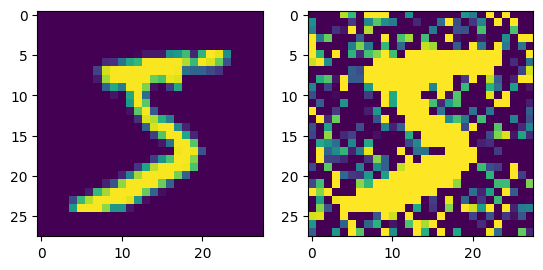

In [5]:
img = train_data.data[0]
noise_img = gaussian_noise(img)

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.subplot(1, 2, 2)
plt.imshow(noise_img)

In [6]:
from torch.utils.data.dataset import Dataset

class Denoising(Dataset):
    def __init__(self):

        self.mnist = MNIST(root='./',train=True,download=True,transform=ToTensor())
        self.data = []

        for temp in range(len(self.mnist)):
            noise_input = gaussian_noise(self.mnist.data[temp])
            input_tensor = torch.tensor(noise_input)
            self.data.append(torch.unsqueeze(input_tensor, dim = 0))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, i):
        data = self.data[i]
        label = self.mnist.data[i]/255
        return data, label

In [7]:
import torch.nn as nn

class BasicBlock(nn.Module):
    def __init__(self,in_channel, out_channel, hidden_dim):
        super(BasicBlock,self).__init__()

        self.conv1 = nn.Conv2d(in_channel,
                               hidden_dim,
                               kernel_size=3,
                               padding=1
                               )

        self.conv2 = nn.Conv2d(hidden_dim,
                               out_channel,
                               kernel_size=3,
                               padding=1
                               )

        self.relu = nn.ReLU()

    def forward(self,x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)

        return x


In [12]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder,self).__init__()

        self.conv1 = BasicBlock(1,16,16)
        self.conv2 = BasicBlock(16,8,8)

        self.pool = nn.AvgPool2d(kernel_size = 2, stride = 2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.pool(x)

        return x

In [13]:
from torchsummary import summary

In [14]:
encoder = Encoder()

In [15]:
summary(encoder,input_size=(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
              ReLU-2           [-1, 16, 28, 28]               0
            Conv2d-3           [-1, 16, 28, 28]           2,320
              ReLU-4           [-1, 16, 28, 28]               0
        BasicBlock-5           [-1, 16, 28, 28]               0
         AvgPool2d-6           [-1, 16, 14, 14]               0
            Conv2d-7            [-1, 8, 14, 14]           1,160
              ReLU-8            [-1, 8, 14, 14]               0
            Conv2d-9            [-1, 8, 14, 14]             584
             ReLU-10            [-1, 8, 14, 14]               0
       BasicBlock-11            [-1, 8, 14, 14]               0
        AvgPool2d-12              [-1, 8, 7, 7]               0
Total params: 4,224
Trainable params: 4,224
Non-trainable params: 0
-----------------------------------

In [ ]:
#nn.ConvTranspose2d (kernerl = 2, stride=2)

#(SIZE - 1) * stride - 2*padding + kernel_size

#(7-1) * 2 - 2*0 + 2 = 14

In [16]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()

        self.conv1 = BasicBlock(8,8,8)
        self.conv2 = BasicBlock(8,16,16)
        self.conv3 = nn.Conv2d(16,1,kernel_size=3,padding=1)

        self.upsample1= nn.ConvTranspose2d(8,8,kernel_size=2,stride=2)
        self.upsample2= nn.ConvTranspose2d(16,16,kernel_size=2,stride=2)

    def forward(self, x):
        x = self.conv1(x) # 8,7,7
        x = self.upsample1(x)
        x = self.conv2(x)
        x = self.upsample2(x)
        x = self.conv3(x) # 1,28,28

        return x

In [17]:
decoder = Decoder()
summary(decoder,input_size=(8,7,7))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1              [-1, 8, 7, 7]             584
              ReLU-2              [-1, 8, 7, 7]               0
            Conv2d-3              [-1, 8, 7, 7]             584
              ReLU-4              [-1, 8, 7, 7]               0
        BasicBlock-5              [-1, 8, 7, 7]               0
   ConvTranspose2d-6            [-1, 8, 14, 14]             264
            Conv2d-7           [-1, 16, 14, 14]           1,168
              ReLU-8           [-1, 16, 14, 14]               0
            Conv2d-9           [-1, 16, 14, 14]           2,320
             ReLU-10           [-1, 16, 14, 14]               0
       BasicBlock-11           [-1, 16, 14, 14]               0
  ConvTranspose2d-12           [-1, 16, 28, 28]           1,040
           Conv2d-13            [-1, 1, 28, 28]             145
Total params: 6,105
Trainable params: 6

In [18]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()

        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x) # 1, 28, 28
        x = torch.squeeze(x) # 28, 28

        return x

In [19]:
from torch.utils.data.dataloader import DataLoader
from torch.optim.adam import Adam
device = 'cuda' if torch.cuda.is_available() else 'cpu'

trainset = Denoising()
train_loader = DataLoader(trainset,batch_size=32)

model = Model().to(device)

optim = Adam(model.parameters(),lr=1e-3)

<ipython-input-3-612d56948bcf>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gaussian_data_x = torch.tensor(gaussian_data_x)
<ipython-input-6-cdb2c7cb3768>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_tensor = torch.tensor(noise_input)


In [21]:
import tqdm
for epoch in range(20):
    for data, label in tqdm.tqdm(train_loader):
        optim.zero_grad()
        pred = model(data.to(device))

        loss = nn.MSELoss()(torch.squeeze(pred), label.to(device))
        loss.backward()
        optim.step()

    print(f'Epoch : {epoch+1} loss : {loss.item()}')

100%|██████████| 1875/1875 [01:30<00:00, 20.77it/s]


Epoch : 1 loss : 0.01280798390507698


100%|██████████| 1875/1875 [01:30<00:00, 20.66it/s]


Epoch : 2 loss : 0.010700530372560024


100%|██████████| 1875/1875 [01:43<00:00, 18.07it/s]


Epoch : 3 loss : 0.009840470738708973


100%|██████████| 1875/1875 [02:26<00:00, 12.81it/s]


Epoch : 4 loss : 0.009701359085738659


100%|██████████| 1875/1875 [01:37<00:00, 19.24it/s]


Epoch : 5 loss : 0.009632816538214684


100%|██████████| 1875/1875 [01:31<00:00, 20.46it/s]


Epoch : 6 loss : 0.009363609366118908


100%|██████████| 1875/1875 [01:30<00:00, 20.68it/s]


Epoch : 7 loss : 0.009403557516634464


100%|██████████| 1875/1875 [01:28<00:00, 21.12it/s]


Epoch : 8 loss : 0.00859133806079626


100%|██████████| 1875/1875 [01:28<00:00, 21.23it/s]


Epoch : 9 loss : 0.008436508476734161


100%|██████████| 1875/1875 [01:29<00:00, 21.02it/s]


Epoch : 10 loss : 0.008038721978664398


100%|██████████| 1875/1875 [01:28<00:00, 21.26it/s]


Epoch : 11 loss : 0.00794263556599617


100%|██████████| 1875/1875 [01:29<00:00, 20.90it/s]


Epoch : 12 loss : 0.00792461447417736


100%|██████████| 1875/1875 [01:29<00:00, 21.02it/s]


Epoch : 13 loss : 0.007907481864094734


100%|██████████| 1875/1875 [01:28<00:00, 21.25it/s]


Epoch : 14 loss : 0.007815069518983364


100%|██████████| 1875/1875 [01:30<00:00, 20.79it/s]


Epoch : 15 loss : 0.007804255932569504


100%|██████████| 1875/1875 [01:27<00:00, 21.33it/s]


Epoch : 16 loss : 0.007728843484073877


100%|██████████| 1875/1875 [01:27<00:00, 21.39it/s]


Epoch : 17 loss : 0.007796185556799173


100%|██████████| 1875/1875 [01:28<00:00, 21.07it/s]


Epoch : 18 loss : 0.007725602015852928


100%|██████████| 1875/1875 [01:28<00:00, 21.16it/s]


Epoch : 19 loss : 0.007724680472165346


100%|██████████| 1875/1875 [01:27<00:00, 21.35it/s]

Epoch : 20 loss : 0.007701446767896414


<ipython-input-3-612d56948bcf>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gaussian_data_x = torch.tensor(gaussian_data_x)


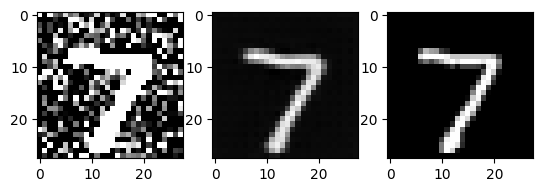

In [22]:
model.cpu()
model.eval()
with torch.no_grad():
    img = test_data.data[0]
    noise = gaussian_noise(img) # 28,28

    input = torch.unsqueeze(noise, dim = 0)
    input.type(torch.FloatTensor)
    input.to(device)
    input = torch.unsqueeze(input, dim = 0)

    plt.subplot(1,3,1)
    plt.imshow(torch.squeeze(noise), cmap = 'gray')
    plt.subplot(1,3,2)
    plt.imshow(torch.squeeze(model(input)), cmap = 'gray')
    plt.subplot(1,3,3)
    plt.imshow(torch.squeeze(img), cmap = 'gray')
    plt.show()